# MDLE - Exercise 1.1
### Collaborative Filtering
##### Authors: Pedro Duarte 97673, Pedro Monteiro 97484

Import necessary modules

In [1]:
import math

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

from matplotlib import pyplot as plt

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

from operator import add

Declare constants

In [2]:
# Spark Constants
APP_NAME = 'assignment1'
MASTER = 'local[*]'

# Input Constants
INPUT_METADATA_FILE = 'tracks.csv'
INPUT_FEATURES_FILE = 'features.csv'

# Data Columns
COLUMN_TRACK_ID = 'track_id'
COLUMN_SET = 'set'
COLUMN_SUBSET = 'subset'

# Application Constants
SUBSET_SMALL_VALUE = 'small'

In [3]:
tracks = pd.read_csv(INPUT_METADATA_FILE, index_col=0, header=[0, 1])
features = pd.read_csv(INPUT_FEATURES_FILE, index_col=0, header=[0, 1, 2])

In [4]:
small = tracks[tracks[COLUMN_SET, COLUMN_SUBSET] == SUBSET_SMALL_VALUE]
small.shape

(8000, 52)

In [5]:
ids = set(small.index.to_list())
features_sm = features.loc[ids]
features_sm.shape

/tmp/ipykernel_81446/1115158780.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  features_sm = features.loc[ids]


(8000, 518)

In [6]:
X = features_sm.values
X = StandardScaler().fit(X).transform(X)

In [7]:
results = {}

for k in range(8, 17):
    clusters = AgglomerativeClustering(n_clusters=k).fit_predict(X)

    clusters_separated = [X[clusters == i] for i in range(k)]
    centroids = [cluster.mean(axis=0) for cluster in clusters_separated]

    radius = [max(np.linalg.norm(p - centroids[i]) for p in clusters_separated[i]) for i in range(k)]
    diameter = [np.max(pairwise_distances(cluster)) for cluster in clusters_separated]

    # !! division by 0 !!
    density_r = [len(clusters_separated[i]) / (radius[i]**2) if radius[i] != 0 else math.inf for i in range(k)]
    density_d = [len(clusters_separated[i]) / (diameter[i]**2) if diameter[i] != 0 else math.inf for i in range(k)]

    results[k] = {
        'radius': radius,
        'diameter': diameter,
        'density_r': density_r,
        'density_d': density_d,
    }

    print(f'For k = {k}:')
    print('Radius:', radius)
    print('Diameter:', diameter)
    print('Density (r2):', density_r)
    print('Density (d2):', density_d)
    print()

For k = 8:
Radius: [131.9635070863535, 85.61707555250149, 57.70367758776073, 108.58973665171192, 56.55991248912924, 0.0, 69.26651356236508, 0.0]
Diameter: [173.98817814544742, 104.32765325996061, 78.29800458030583, 138.6511252678381, 80.15796245946396, 0.0, 86.41438670574432, 0.0]
Density (r2): [0.12604534947908394, 0.19426260600852557, 0.9247039305792399, 0.005681947844095345, 0.3622980347779691, inf, 0.015423575461012385, inf]
Density (d2): [0.07250952221003852, 0.13083113598178184, 0.502236533071095, 0.003485202408848669, 0.1803807122132652, inf, 0.009909679658004903, inf]

For k = 9:
Radius: [57.70367758776073, 85.61707555250149, 131.53468744381067, 108.58973665171192, 56.55991248912924, 0.0, 69.26651356236508, 0.0, 73.19915536057896]
Diameter: [78.29800458030583, 104.32765325996061, 173.98817814544742, 138.6511252678381, 80.15796245946396, 0.0, 86.41438670574432, 0.0, 93.5137932752037]
Density (r2): [0.9247039305792399, 0.19426260600852557, 0.05670069902810301, 0.00568194784409534

### 1.2

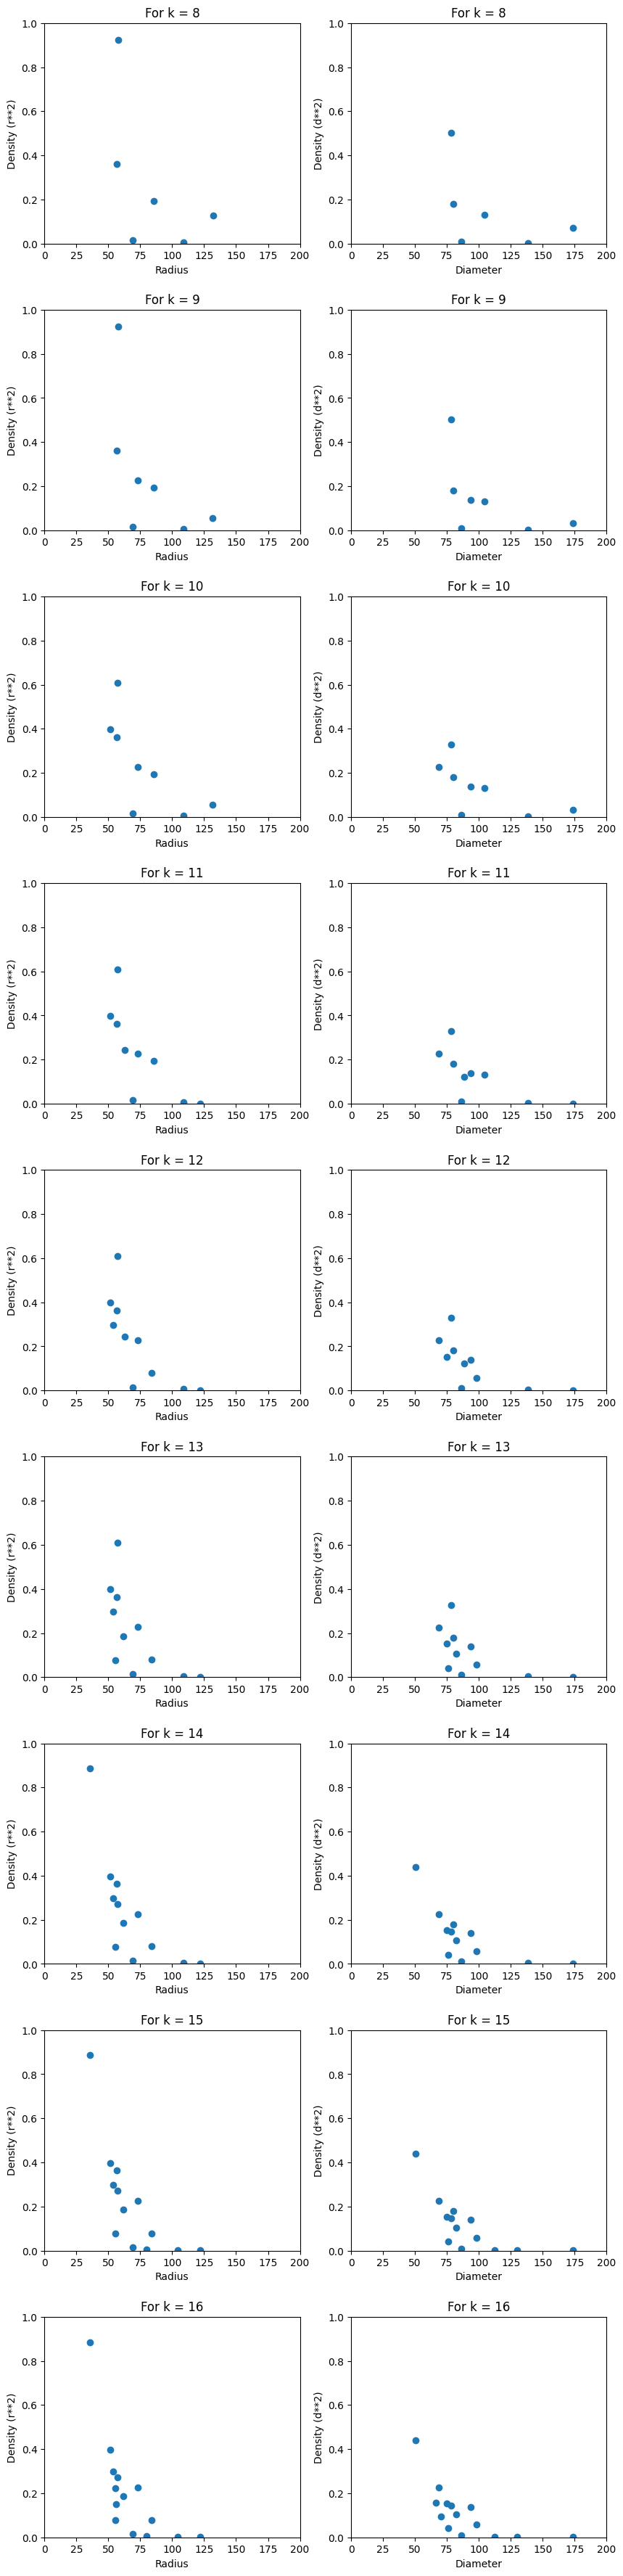

In [8]:
ks = list(results.keys())
fig = plt.figure()

fig.set_figwidth(10)
fig.set_figheight(45)
fig.set_animated(True)
fig.subplots_adjust(hspace=.3)

for i in range(len(ks)):
  k = ks[i]

  invalid_idxs = [i for i in range(len(results[k]['radius'])) if results[k]['radius'][i] == math.inf or results[k]['density_r'][i] == math.inf]
  radius_results = [results[k]['radius'][i] for i in range(len(results[k]['radius'])) if i not in invalid_idxs]
  density_r_results = [results[k]['density_r'][i] for i in range(len(results[k]['density_r'])) if i not in invalid_idxs]

  invalid_idxs = [i for i in range(len(results[k]['diameter'])) if results[k]['diameter'][i] == math.inf or results[k]['density_d'][i] == math.inf]
  diameter_results = [results[k]['diameter'][i] for i in range(len(results[k]['diameter'])) if i not in invalid_idxs]
  density_d_results = [results[k]['density_d'][i] for i in range(len(results[k]['density_d'])) if i not in invalid_idxs]

  sub_r = fig.add_subplot(len(ks), 2, 2*i+1)
  sub_r.scatter(radius_results, density_r_results)
  sub_r.set_xlabel('Radius')
  sub_r.set_ylabel('Density (r**2)')
  sub_r.set_title(f'For k = {k}')
  sub_r.set_xlim([0, 200])
  sub_r.set_ylim([0, 1])

  sub_d = fig.add_subplot(len(ks), 2, 2*i+2)
  sub_d.scatter(diameter_results, density_d_results)
  sub_d.set_xlabel('Diameter')
  sub_d.set_ylabel('Density (d**2)')
  sub_d.set_title(f'For k = {k}')
  sub_d.set_xlim([0, 200])
  sub_d.set_ylim([0, 1])

plt.show()

[[0.12604534947908394, 0.19426260600852557, 0.9247039305792399, 0.005681947844095345, 0.3622980347779691, inf, 0.015423575461012385, inf], [0.9247039305792399, 0.19426260600852557, 0.05670069902810301, 0.005681947844095345, 0.3622980347779691, inf, 0.015423575461012385, inf, 0.22657216113253717], [0.05670069902810301, 0.19426260600852557, 0.6099742984570575, 0.005681947844095345, 0.3622980347779691, inf, 0.015423575461012385, inf, 0.22657216113253717, 0.39767930431635096], [0.19426260600852557, 0.24347792275059751, 0.6099742984570575, 0.005681947844095345, 0.3622980347779691, inf, 0.015423575461012385, inf, 0.22657216113253717, 0.39767930431635096, 0.0018163481633517136], [0.24347792275059751, 0.005681947844095345, 0.6099742984570575, 0.22657216113253717, 0.3622980347779691, 0.07895781538675316, 0.015423575461012385, inf, 0.2977743757267385, 0.39767930431635096, 0.0018163481633517136, inf], [0.6099742984570575, 0.005681947844095345, 0.1868272641542112, 0.22657216113253717, 0.3622980347

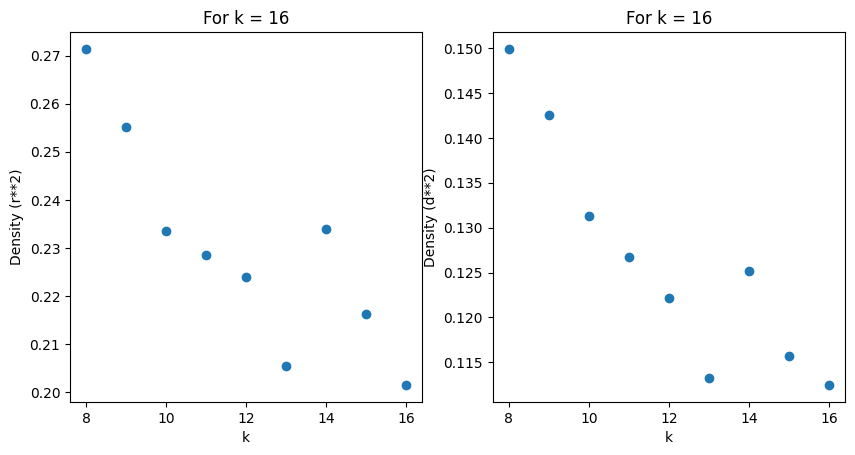

In [9]:
ks = list(results.keys())
fig = plt.figure()

fig.set_figwidth(10)
fig.set_animated(True)

valid_r_ds = { k: [d for d in results[k]['density_r'] if d != math.inf] for k in ks }
valid_d_ds = { k: [d for d in results[k]['density_d'] if d != math.inf] for k in ks }

print([results[k]['density_r'] for k in ks])
print(valid_r_ds)
print([sum(valid_r_ds[k])/len(valid_r_ds[k]) for k in ks])

sub_r = fig.add_subplot(1, 2, 1)
sub_r.scatter(ks, [sum(valid_r_ds[k])/len(valid_r_ds[k]) for k in ks])
sub_r.set_xlabel('k')
sub_r.set_ylabel('Density (r**2)')
sub_r.set_title(f'For k = {k}')

print([results[k]['density_d'] for k in ks])
print(valid_d_ds)
print([sum(valid_d_ds[k])/len(valid_d_ds[k]) for k in ks])

sub_d = fig.add_subplot(1, 2, 2)
sub_d.scatter(ks, [sum(valid_d_ds[k])/len(valid_d_ds[k]) for k in ks])
sub_d.set_xlabel('k')
sub_d.set_ylabel('Density (d**2)')
sub_d.set_title(f'For k = {k}')

plt.show()

We chose k=8

In [10]:
def bfr(dataset, k, max_iterations):
    centroids = dataset[np.random.choice(dataset.shape[0], k, replace=False)]

    for i in range(max_iterations):
        print('Iteraction ', i+1, '...', sep='')

        old_centroids = centroids.copy()
        #Distancia norm + treshold
        assignments = np.array([np.argmin(np.linalg.norm(point - centroids, axis=1)) for point in dataset])
        centroids = np.array([dataset[assignments == i].mean(axis=0) for i in range(k)])
        
        if np.array_equal(centroids, old_centroids):
            break

    return centroids, assignments

In [11]:
X_full = features.values
X_full = StandardScaler().fit(X_full).transform(X_full)

In [12]:
k=8
centroids, cluster_idxs = bfr(X_full, k, 10000)

Iteraction 1...
Iteraction 2...
Iteraction 3...
Iteraction 4...
Iteraction 5...
Iteraction 6...
Iteraction 7...
Iteraction 8...
Iteraction 9...
Iteraction 10...
Iteraction 11...
Iteraction 12...
Iteraction 13...
Iteraction 14...
Iteraction 15...
Iteraction 16...
Iteraction 17...
Iteraction 18...
Iteraction 19...
Iteraction 20...
Iteraction 21...
Iteraction 22...
Iteraction 23...
Iteraction 24...
Iteraction 25...
Iteraction 26...
Iteraction 27...
Iteraction 28...
Iteraction 29...
Iteraction 30...
Iteraction 31...
Iteraction 32...
Iteraction 33...
Iteraction 34...
Iteraction 35...
Iteraction 36...
Iteraction 37...
Iteraction 38...
Iteraction 39...
Iteraction 40...
Iteraction 41...
Iteraction 42...
Iteraction 43...
Iteraction 44...
Iteraction 45...
Iteraction 46...
Iteraction 47...
Iteraction 48...
Iteraction 49...
Iteraction 50...
Iteraction 51...
Iteraction 52...
Iteraction 53...
Iteraction 54...
Iteraction 55...
Iteraction 56...
Iteraction 57...
Iteraction 58...
Iteraction 59...
Iterac

Configuration and Initialization of Spark

- Parameters:
    - `APP_NAME` (string): the name of the Spark application
    - `MASTER` (string): the URL of the Spark master node
<br></br>
- Returns:
    - `sc` (SparkContext): the Spark context for the given application and master
    - `spark` (SparkSession): the Spark session for the given application and master

In [13]:
conf = SparkConf().setAppName(APP_NAME).setMaster(MASTER)
sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession.builder.appName(APP_NAME).master(MASTER).getOrCreate()

23/05/04 11:00:49 WARN Utils: Your hostname, pedro-duarte resolves to a loopback address: 127.0.1.1; using 192.168.61.10 instead (on interface wlp2s0)
23/05/04 11:00:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/04 11:00:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [14]:
def plot_genres_chart_info(ax, clusterid):
  cluster_ids = features[cluster_idxs == clusterid].index.to_list()
  cluster_genres = tracks.loc[cluster_ids]['track', 'genre_top'].tolist()

  cluster_genres = sc.parallelize(cluster_genres).map(lambda v: (v, 1)).reduceByKey(add).collectAsMap()

  ax.bar([str(key) for key in cluster_genres.keys()], cluster_genres.values())

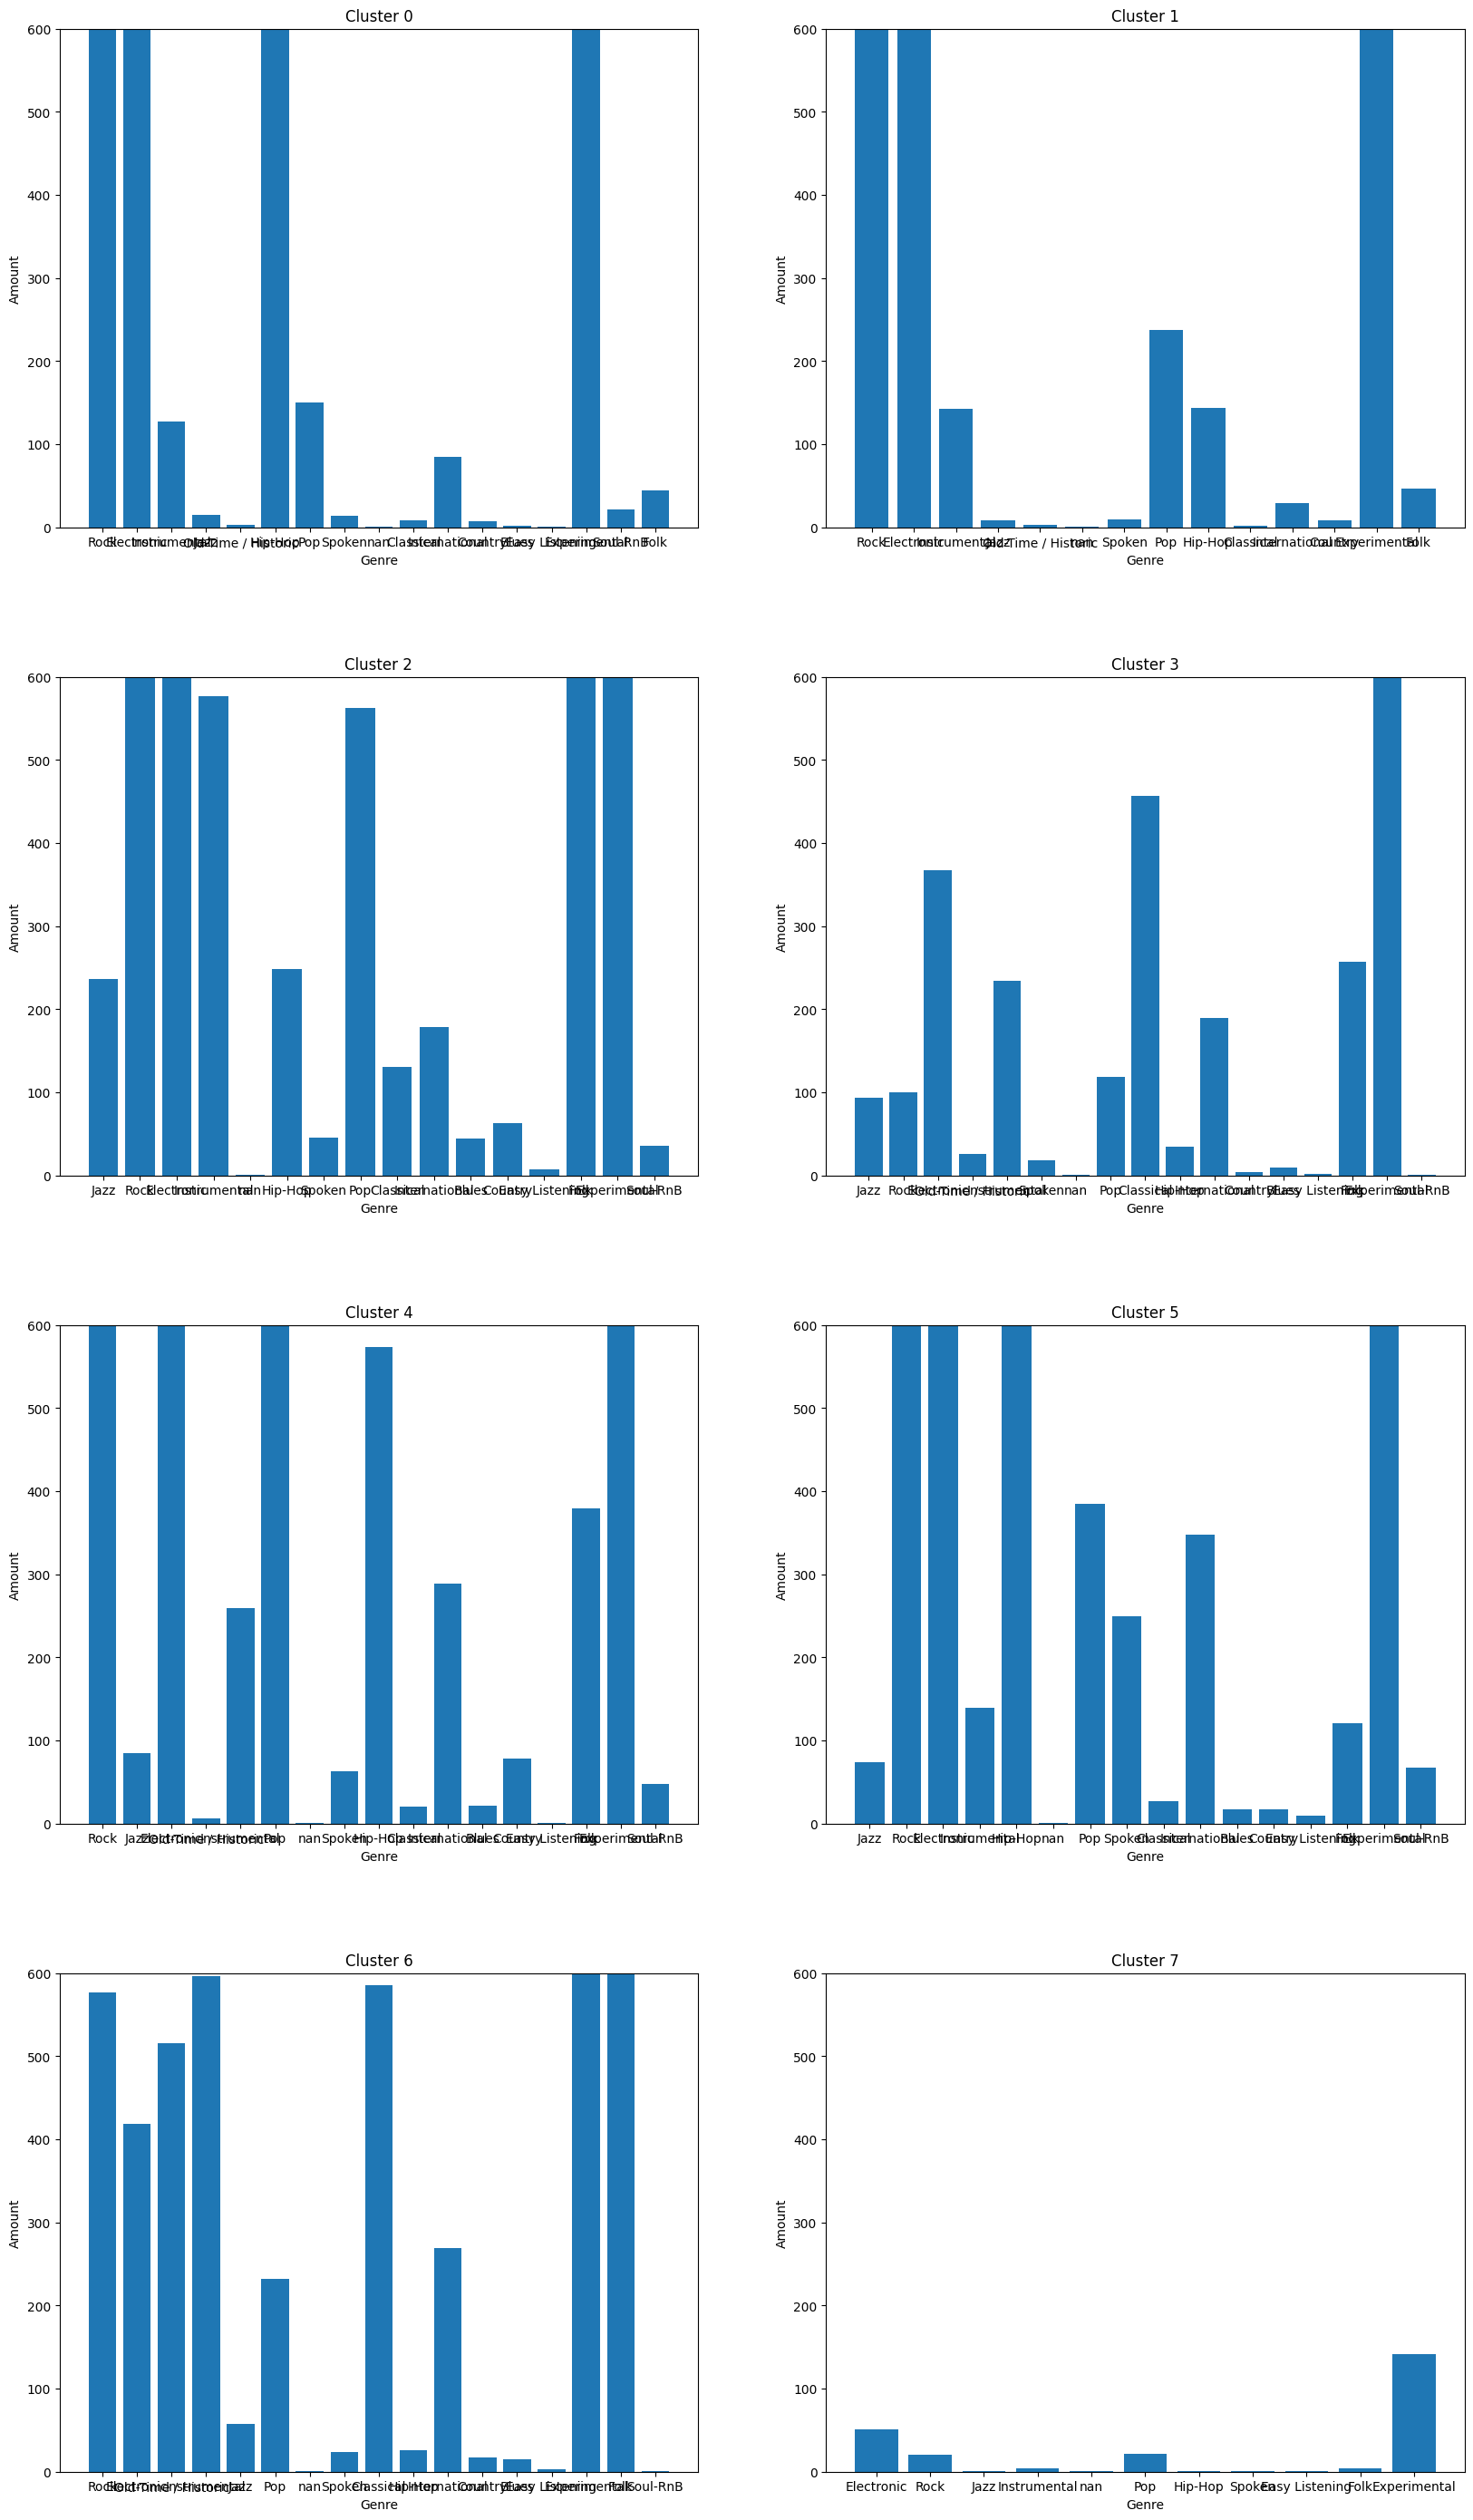

In [15]:
fig = plt.figure()

fig.set_figwidth(20)
fig.set_figheight(35)
fig.set_animated(True)
fig.subplots_adjust(hspace=.3)

k = 8

for i in range(k):
  ax = fig.add_subplot(math.ceil(k/2), 2, i+1)
  plot_genres_chart_info(ax, i)
  ax.set_ylim([0, 600])
  ax.set_xlabel('Genre')
  ax.set_ylabel('Amount')
  ax.set_title(f'Cluster {i}')

plt.show()